In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random as rand
import os

In [2]:
def get_harris_corners(img, show=False):

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    
    #result is dilated for marking the corners, not important - do we need this?
    dst_dilated = cv2.dilate(dst,None)

    if show:

        # Threshold for an optimal value, it may vary depending on the image - do we need this?
        # dst_dilated>0.01*dst_dilated.max() filters out the points
        # [0, 0, 255] marks the filtered points as red
        img[dst_dilated>0.01*dst_dilated.max()]=[0,0,255] 

        cv2.imshow('dst',img)
        if cv2.waitKey(0) & 0xff == 27:
            cv2.destroyAllWindows()

    #dst_dilated = dst_dilated[dst_dilated>0.01*dst_dilated.max()]
    img_copy=img.copy()
    img_copy[dst_dilated>0.01*dst_dilated.max()]=[255,0,0]
    
    plt.figure(figsize=(5,5))
    plt.imshow(img_copy)
    plt.title('raw corners')
    #plt.savefig("./YourDirectoryID_p1/Phase1/Data/Train/mid_outputs/harriscorners_image.jpg")
    plt.show()
    return dst

In [3]:
def max_in_local(local_mat, threshval):
    max_val = np.max(local_mat)
    if max_val >= threshval:
        rows, cols = local_mat.shape
        #operation with Time o(n) and space o(1)
        for i in range(rows):
            for j in range(cols):
                if local_mat[i, j] == max_val:
                    return i, j
    return None 

In [4]:
def imgregionalmax(dst,patch_size):
    '''
    This function identifies all pixels that are local maxima in their neighborhood
    (determined by patch_size) and returns a dictionary with (row, col)-pixel_intensity
    key-value pairs, where the pixel_intensity is the corner-detection value as given in 
    dst

    inputs:
        dst: Output of image after applying corner detection (should be a 2D array)

    outputs:
        map_cimg: dictionary with keys as (row, col) cooridnate of a pixel and 
        value as corner detection output for that pixel
    '''
    #first get a threshold to ensure that the pixel previously qualified as corner
    thresh_dst=0.01*dst.max()
    #create a hash map of local maxima coords and its dst
    #choose a patch of patch_size just to take out numpy
    rows,cols = dst.shape
    t_row=0
    map_cimg={}
    while t_row<rows:
        t_col=0
        while t_col<cols:
            row_start=t_row
            row_end=min(t_row+patch_size,rows)
            col_start=t_col
            col_end=min(t_col+patch_size,cols)
            tmp_array=dst[row_start:row_end,col_start:col_end]
            local_coords=max_in_local(tmp_array,thresh_dst)
            if local_coords:
                global_coords=(row_start+local_coords[0],col_start+local_coords[1])
                map_cimg[global_coords]=dst[global_coords]
            t_col+=patch_size
        t_row+=patch_size
              
    return map_cimg

In [5]:

def ANMS(img,dst, n_best):
    """

    This function identifies "n_best" keypoints that are true local maxima for
    corner detection 

    inputs:
        dst: Output of image after applying corner detection (should be a 2D array)
    
    Returns: 
        best_n_coordinates: list of tuple (row, col) values of n_best keypoints
    """

    patch_size = 5
    map_cimg = imgregionalmax(dst, patch_size)
    map_r = {}
    print("[ANMS] Total number of local maxima keypoints",len(map_cimg))
    
    # Calculate the minimum distance for each keypoint
    for key1 in map_cimg:
        r = np.inf
        for key2 in map_cimg:
            if key1 != key2:
                ed = np.inf
                if map_cimg[key2] > map_cimg[key1]:
                    ed = (key1[1] - key2[1]) ** 2 + (key1[0] - key2[0]) ** 2
                if ed < r:
                    r = ed
        map_r[key1] = r
    
    # Sort the coordinates based on their score in descending order
    sorted_coordinates = sorted(map_r.items(), key=lambda item: item[1], reverse=True)
    
    # Return the best n coordinates
    best_n_coordinates = [coord for coord, _ in sorted_coordinates[:n_best]]
    ###added to save image ###
    
    
    img_copy = img.copy()  
   
    for (row, col) in best_n_coordinates:
        if 0 <= row < img_copy.shape[0] and 0 <= col < img_copy.shape[1]:  # Ensure within bounds
            cv2.circle(img_copy, (col, row), 3, (255, 0, 0), -1)  # Red circle (BGR format)
    
    
    
    plt.figure(figsize=(10,5))
    plt.imshow(img_copy)
    plt.title('anms_image')
    #plt.savefig("./YourDirectoryID_p1/Phase1/Data/Train/mid_outputs/anms_image.jpg")
    plt.show()
    
    #print('best cordinates',best_n_coordinates)
    return best_n_coordinates

In [6]:
def get_feature_descriptors(img, feature_points):

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    feature_descriptors = []

    for keypoint in feature_points:
        (row, col) = keypoint

        patch_length = 41
        half_patch_length = patch_length//2

        # Numpy automatically stops at last row/col if kernel size exceeds image bounds
        roi = gray[max(0, row - half_patch_length):row + half_patch_length + 1,
                max(0, col - half_patch_length):col + half_patch_length + 1]

        feature_descriptor = cv2.GaussianBlur(roi, ksize=(41, 41), sigmaX=0)

        subsampled_feature_descriptor =  cv2.resize(feature_descriptor, (8, 8))

        feature_vector = subsampled_feature_descriptor.flatten()

        standardized_feature_vector = (feature_vector - np.mean(feature_vector)) / np.std(feature_vector)

        feature_descriptors.append(standardized_feature_vector)

    return feature_descriptors

In [7]:
def match_features(feature_descriptors_1 ,feature_descriptors_2, ratio=0.5):
    '''
    inputs:
        feature_descriptors_1: List of [64x1] features for n keypoints in image 1
        feature_descriptors_1: List of [64x1] features for n keypoints in image 2
    outputs:
        matching_points: List of n cv2.DMatch<keypoint_1_id, keypoint_2_id, distance>
                         objects, where keypoint_1_id and keypoint_2_id are indices
                         of keypoints as indexed in feature_descriptors_1 and
                         feature_descriptors_2 respectively, and distance is the
                         sum-of-squared differences distance between feature
                         descriptors of these keypoints.
    '''

    print("[Match Features] Feature descriptors 1 length: ", len(feature_descriptors_1))
    print("[Match Features] Feature descriptors 2 length: ", len(feature_descriptors_2))
    assert len(feature_descriptors_1) == len(feature_descriptors_2), "Feature descriptor lengths should match!"
    
    matching_points = []

    for idx1, feature_1 in enumerate(feature_descriptors_1):
        # Create placeholder values for top 2 best matches for keypoint 1
        # This array list should be sorted in ascending order by DMatch.distance
        top_2_matches = [cv2.DMatch(_queryIdx=-1, _trainIdx=-1, _distance=np.inf-1.0), 
                                   cv2.DMatch(_queryIdx=-1, _trainIdx=-1, _distance=np.inf)]
        
        # Go through features for all keypoints to find the top 2 matches
        for idx2, feature_2 in enumerate(feature_descriptors_2):
            if idx1 != idx2:

                # Calculate sum of squared difference between features of keypoints
                distance = np.sum((feature_1 - feature_2)**2)

                # First check if calculated distance is less than 1st saved match distance
                if distance < top_2_matches[0].distance:

                    # Replace 2nd saved match with 1st saved match
                    top_2_matches[1] = top_2_matches[0]

                    # Replace 1st saved match with new distance
                    top_2_matches[0] = cv2.DMatch(_queryIdx=idx1, _trainIdx=idx2, _distance=distance)

                elif distance > top_2_matches[0].distance and distance < top_2_matches[1].distance:
                # If calculated distance is greater than first saved distance 
                # but smaller than second saved distance
                    top_2_matches[1] = top_2_matches[0]

        
        # Add top match if ration of distances between 1st and 2nd match < 0.5
        if top_2_matches[0].distance/top_2_matches[1].distance < 0.5:
            matching_points.append(top_2_matches[0])

    return matching_points

In [8]:
def SSD(src, dst, h):
    '''
    inputs:
        src: keypoint locations in (row, col) format
        dst: keypoint locations in (row, col) format
        h: homography matrix
    '''

    # Convert to homogeneous coordinates
    src_homogeneous = np.array([src[1], src[0], 1], dtype=np.float32)
    dst_homogeneous = np.array([dst[1], dst[0], 1], dtype=np.float32)
    
    # Apply the homography transformation to the source point
    transformed_point = np.dot(h, src_homogeneous)
    transformed_point /= transformed_point[2]  # Normalize to homogeneous coordinates
    
    # Calculate the squared difference (SSD) between the transformed point and the destination point
    ssd = np.sum((transformed_point[:2] - dst_homogeneous[:2]) ** 2)

    return ssd

In [9]:
def construct_matrix(src_list, dst_list):
    """
    Construct a matrix for calculating the perspective transformation.
    src_list and dst_list are lists of tuples in (col, row) (x, y) format.
    """
    # Initialize an empty matrix
    A = np.zeros((0, 9))
    
    # Iterate through the source and destination points
    for (xs, ys), (xd, yd) in zip(src_list, dst_list):
        # Construct the rows for the matrix
        first_row = [xs, ys, 1, 0, 0, 0, -xd * xs, -xd * ys, -xd]
        second_row = [0, 0, 0, xs, ys, 1, -yd * xs, -yd * ys, -yd]
        
        # Append the rows to the matrix
        A = np.vstack([A, first_row, second_row])
    
    # Compute A_T * A
    ATA = np.dot(A.T, A)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(ATA)
    
    # Find the eigenvector corresponding to the smallest eigenvalue
    min_eigenvalue_index = np.argmin(eigenvalues)
    h = eigenvectors[:, min_eigenvalue_index]
    H = h.reshape((3, 3))
    return  H

In [10]:
def rowcol_to_colrow(tuple_list):
    """
    Switch (row, col) tuples to (col, row).

    Args:
        tuple_list (list): List of (row, col) tuples.
    
    Returns:
        list: List of (col, row) tuples.

    # Example usage
    tuple_list = [(1, 2), (3, 4), (5, 6)]
    switched = switch_row_col(tuple_list)
    print(switched)  # Output: [(2, 1), (4, 3), (6, 5)]
    
    """
    return [(col, row) for row, col in tuple_list]


In [11]:

def RANSAC(matches, keypoint_list1, keypoint_list2, delta, n_iter):
    '''
    inputs:
        matches: list of cv2.DMatch objects expressed as indices of keypoints
                 from keypoint_list1 and keypoint_list2, as well as sum of squared
                 difference between feature descriptors of these keypoints
        keypoint_list1: Image 1 ANMS keypoints expressed as (row, col) tuple
        keypoint_list2: Image 2 ANMS keypoints expressed as (row, col) tuple

    '''

    # Construct match lists from matches, keypoint_list1, keypoint_list2
    list1 = [keypoint_list1[m.queryIdx] for m in matches] # (row, col)
    list2 = [keypoint_list2[m.trainIdx] for m in matches] # (row, col)
    
    best_inliercounter = 0
    best_h = np.zeros((3, 3))

    # Get four random pairs
    for iter in range(n_iter):
        rand_indices = rand.sample(range(len(list1)), 4)
        
        # # Convert list of points to np.float32 arrays for homography calculation
        src = [list1[r] for r in rand_indices]
        dst = [list2[r] for r in rand_indices]
        
        # Compute homography (switch src and dst from (row, col) to (col, row) format)
        #h=construct_matrix(rowcol_to_colrow(src),
                             #rowcol_to_colrow(dst))
        h = cv2.getPerspectiveTransform(np.float32(rowcol_to_colrow(src)), np.float32(rowcol_to_colrow(dst)))
        
        #h = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
        # SSD on each element of matches
        tmp_inliercounter = 0
        for i in range(len(list1)):
            # (SSD takes (row, col) formate and converts to x,y (col, row))
            if SSD(list1[i], list2[i], h) < delta:
                
                tmp_inliercounter += 1
        
        # If more than 90% inliers found, break early
        if tmp_inliercounter > 0.9 * len(list1):
            best_h = h
            break
        
        # Track the best homography with the most inliers
        if tmp_inliercounter > best_inliercounter:
            best_inliercounter = tmp_inliercounter
            best_h = h

    # Create lists of points with inliers using best homography so far
    mid_list1 = []
    mid_list2 = []
    for i in range(len(list1)):
        # (SSD takes (row, col) formate and converts to x,y (col, row))
        if SSD(list1[i], list2[i], best_h) < delta:
            mid_list1.append(list1[i]) # (row, col)
            mid_list2.append(list2[i]) # (row, col)
    print('best h is ',best_h)

    best_h=construct_matrix(rowcol_to_colrow(mid_list1),
                            rowcol_to_colrow(mid_list2))
    print('best h is ',best_h)
    
    # Create final list of points with inliers using nest homography
    new_list1 = []
    new_list2 = []
    for i in range(len(list1)):
        # (SSD takes (row, col) formate and converts to x,y (col, row))
        if SSD(list1[i], list2[i], best_h) < delta:
            new_list1.append(list1[i]) # (row, col)
            new_list2.append(list2[i]) # (row, col)
    print(f'new_list len {len(new_list1)},{len(new_list2)}')
    
    return new_list1, new_list2, best_h

In [12]:
def find_corners(list1, best_h):
    new_cords = []
    for pt in list1:
        y,x=pt[1],pt[0]
        ip = np.array([x, y], dtype=np.float32)  # Use (x, y) as typical coordinates
        
        # Convert to homogeneous coordinates (add a 1 to make it (x, y, 1))
        ip_h = np.append(ip, 1)  # Becomes [x, y, 1]
        
        # Apply homography
        new_point_h = np.dot(best_h, ip_h)
        
        # Convert back to Cartesian coordinates (divide by the last component)
        new_point = new_point_h[:2] / new_point_h[2]
        #new_point=new_point_h
        #print('x y are',x ,y)
           # print('New point:', new_point)
        new_cords.append(new_point)
    print('new cords',new_cords)
    return new_cords

In [13]:
def extend_canvas(img1, img2, h):
    # Get dimensions of img1 and img2
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Compute the warped corners of img1
    corners = np.array([[0, 0], [w1, 0], [w1, h1], [0, h1]], dtype=np.float32)
    warped_corners = cv2.perspectiveTransform(corners[None, :, :], h)[0]
    print('shape of warmped',warped_corners.shape)
    tmp_corners=corners
    print('shape of tmpwarmped',tmp_corners.shape)
    tmp_corners=find_corners(tmp_corners,h)
    print('new corners are ',warped_corners)
    # Find the bounding box of the warped corners
    x_min = min(warped_corners[:, 0].min(), 0)
    y_min = min(warped_corners[:, 1].min(), 0)
    x_max = max(warped_corners[:, 0].max(), w2)
    y_max = max(warped_corners[:, 1].max(), h2)

    # Compute the size of the new canvas
    new_width = int(x_max - x_min)
    new_height = int(y_max - y_min)

    # Compute the translation matrix to shift the content to fit in the canvas
    translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])

    # Warp img1 onto the extended canvas
    extended_h = translation @ h  # Combine translation with the homography
    warped_img1 = cv2.warpPerspective(img1, extended_h, (new_width, new_height))

    # Place img2 onto the extended canvas
    canvas = warped_img1.copy()
    canvas[-int(y_min):-int(y_min) + h2, -int(x_min):-int(x_min) + w2] = img2

    return canvas

In [20]:

def stitch_operation(img_1_path,img_2_path,img_dir):
    # Add any Command Line arguments here
    # Parser = argparse.ArgumentParser()
    # Parser.add_argument('--NumFeatures', default=100, help='Number of best features to extract from each image, Default:100')

    # Args = Parser.parse_args()
    # NumFeatures = Args.NumFeatures

    """
    Read a set of images for Panorama stitching
    
    #root = "/home/speedracer1702/Projects/academic/Computer_Vision/"
    img_dir = "./YourDirectoryID_p1/Phase1/Data/Train/Set1/"

    img_1_path = img_dir + "1.jpg"
    img_2_path = img_dir + "2.jpg"
    
    """
    print('img1 path',img_1_path)
    print('img2 path',img_2_path)
    img1 = cv2.imread(img_1_path)
    img2 = cv2.imread(img_2_path)

    """
	Corner Detection
	Save Corner detection output as corners.png
	"""

    dst1 = get_harris_corners(img1, show=False)
    dst2 = get_harris_corners(img2, show=False)

    """
	Perform ANMS: Adaptive Non-Maximal Suppression
	Save ANMS output as anms.png
	"""

    ANMS_keypoints_1 = ANMS(img1,dst1, 250)
    ANMS_keypoints_2 = ANMS(img2,dst2, 250)

    # print("shape of anms_OUT",len(ANMS_keypoints_1))

    # keypoints = [cv2.KeyPoint(x=col, y=row, size=10) for row, col in ANMS_keypoints_1]
    # gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    # image_with_keypoints = cv2.drawKeypoints(gray, keypoints, None, color=(0, 255, 0))
    # # Display the result
    # cv2.imshow("Keypoints", image_with_keypoints)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # # Mark the coordinates in the image as red
    # for coord in ANMS_keypoints:
    #     y, x = coord  # Extract y and x coordinates
    #     cv2.circle(img1, (x, y), 3,(0,0,255), -1)
    
    # # Save and display the image with marked keypoints
    # cv2.imwrite('anms_output.png', img1)
    # cv2.imshow('ANMS Output', img1)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    

    """
	Feature Descriptors
	Save Feature Descriptor output as FD.png
	"""

    feature_descriptors_1 = get_feature_descriptors(img1, ANMS_keypoints_1)
    feature_descriptors_2 = get_feature_descriptors(img2, ANMS_keypoints_2)

    # # Visualize keypoints on the image
    # image_with_keypoints = cv2.drawKeypoints(gray, keypoints, None, color=(0, 255, 0))

    # # Display the result
    # cv2.imshow("Keypoints", image_with_keypoints)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


    """
	Feature Matching
	Save Feature Matching output as matching.png
	"""

    matches = match_features(feature_descriptors_1, feature_descriptors_2)

    kp1 = [cv2.KeyPoint(x=col, y=row, size=10) for row, col in ANMS_keypoints_1]
    kp2 = [cv2.KeyPoint(x=col, y=row, size=10) for row, col in ANMS_keypoints_2]
    img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    # plt.imshow(img3)
    # plt.show()

    """
	Refine: RANSAC, Estimate Homography
	"""

    # RANSAC_keypoints_1, RANSAC_keypoints_2 are in (row, col) format
    RANSAC_keypoints_1, RANSAC_keypoints_2, h = RANSAC(matches, ANMS_keypoints_1, ANMS_keypoints_2, delta=40, n_iter=500)
    
    """
	Image Warping + Blending
	Save Panorama output as mypano.png
	"""

    # print(RANSAC_keypoints_1, RANSAC_keypoints_2)

    # # Draw keypoints on the first image
    new_kp1 = [cv2.KeyPoint(x=col, y=row, size=10) for row, col in RANSAC_keypoints_1]
    # gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    # image_with_keypoints1 = cv2.drawKeypoints(gray1, keypoints1, None, color=(0, 255, 0))

    # # Draw keypoints on the second image
    new_kp2 = [cv2.KeyPoint(x=col, y=row, size=10) for row, col in RANSAC_keypoints_2]
    # gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    # image_with_keypoints2 = cv2.drawKeypoints(gray2, keypoints2, None, color=(0, 255, 0))
    new_matches = []
    for match in matches:
        if (ANMS_keypoints_1[match.queryIdx] in RANSAC_keypoints_1 and 
            ANMS_keypoints_2[match.trainIdx] in  RANSAC_keypoints_2):
            new_matches.append(match)
    # # Combine the two images side by side
    # combined_image = np.hstack((image_with_keypoints1, image_with_keypoints2))

    # # Display the result
    # cv2.imshow("Keypoints in Both Images", combined_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    img4 = cv2.drawMatches(img1, kp1, img2, kp2, new_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Visualization
    '''
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img3)
    plt.title('All Matches')
    plt.subplot(1, 2, 2)
    plt.imshow(img4)
    plt.title('Inlier Matches after RANSAC')
    plt.show()
    '''
    plt.subplot(1, 2, 1)
    plt.imshow(img3)
    plt.title('All Matches')
    plt.axis('off')  # Remove axis for better visualization
    
    # Second image subplot
    plt.subplot(1, 2, 2)
    plt.imshow(img4)
    plt.title('Inlier Matches after RANSAC')
    plt.axis('off')  # Remove axis for better visualization
    
    # Save the figure as a single image
    plt.tight_layout()  # Adjust layout to avoid overlap
    #output_path = "./YourDirectoryID_p1/Phase1/Data/Train/mid_outputs/ransac.jpg"  # Specify the output file name
    #plt.savefig(output_path, dpi=300, bbox_inches='tight')  # Save at high resolution
    plt.show()



    

    combined_image = extend_canvas(img1, img2, h)
    save_path = os.path.join(img_dir, "stitched_result.jpg")
    #cv2.imwrite(save_path, combined_image)

    cv2.imwrite(save_path,combined_image)
    plt.imshow(combined_image)
    plt.show()
    return save_path

In [21]:
def automate_stitching(train_path):
    # Direct path to a specific set (e.g., Set1)
    set_path = train_path  # You can specify a folder like Set1, etc.

    # Get all image filenames in the set, sorted numerically
    excluded_files = ["stitched_result.jpg", "stitched_image.jpg"]  # Add other filenames to exclude as needed
    
    # Get all image filenames in the folder, sorted numerically, but exclude specific files
    image_files = sorted(
        [f for f in os.listdir(train_path) if f.endswith('.jpg') and f not in excluded_files],
        key=lambda x: int(x.split('.')[0])
    )
    # Initialize the first image path
    current_image_path = os.path.join(set_path, image_files[0])
    
    # Stitch all images in the set one by one
    for i in range(1, len(image_files)):
        next_image_path = os.path.join(set_path, image_files[i])
        
        # Call your stitch_operation function
        #print(f"Stitching {current_image_path} with {next_image_path}")
        current_image_path = stitch_operation(current_image_path, next_image_path, set_path)
    
    # Save the final stitched image
    final_image_path = os.path.join(set_path, "stitched_result.jpg")
    #print(f"Saving the final stitched image at: {final_image_path}")
    #cv2.imwrite(final_image_path, current_image_path)


In [22]:

def main():
    # Add any Command Line arguments here
    # Parser = argparse.ArgumentParser()
    # Parser.add_argument('--NumFeatures', default=100, help='Number of best features to extract from each image, Default:100')

    # Args = Parser.parse_args()
    # NumFeatures = Args.NumFeatures

    """
    Read a set of images for Panorama stitching
    """
    #root = "/home/speedracer1702/Projects/academic/Computer_Vision/"
    '''
    img_dir = "./YourDirectoryID_p1/Phase1/Data/Train/Set22/"

    img_1_path = img_dir + "c4.jpg"
    img_2_path = img_dir + "6.jpg"
    stitch_operation(img_1_path,img_2_path,img_dir)
    '''
    train_path = "../Data/Train/Set1"
    
    automate_stitching(train_path)

img1 path ../Data/Train/Set1/1.jpg
img2 path ../Data/Train/Set1/2.jpg


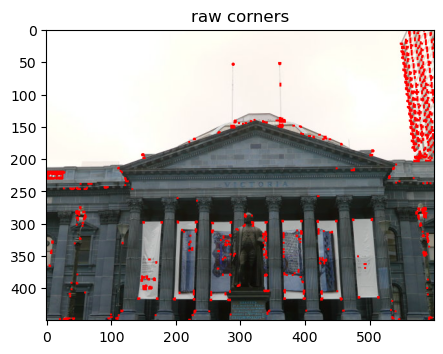

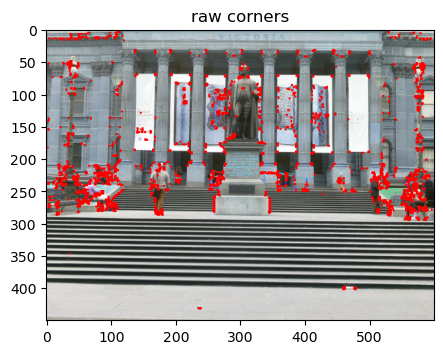

[ANMS] Total number of local maxima keypoints 639


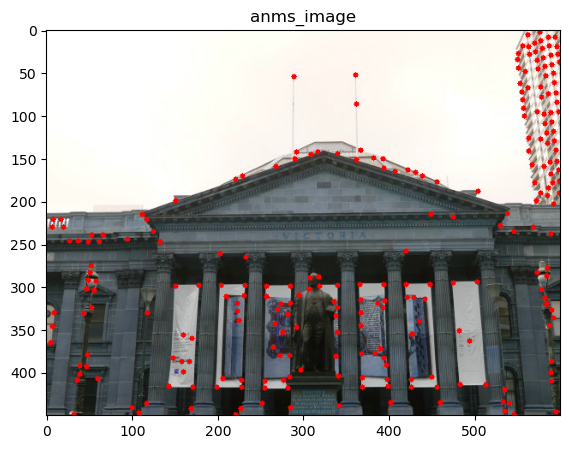

[ANMS] Total number of local maxima keypoints 1077


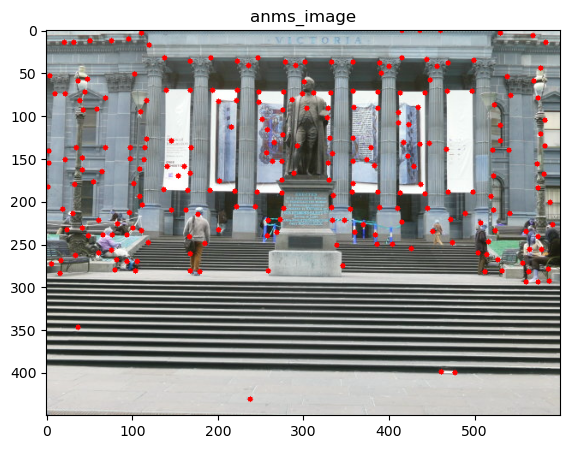

[Match Features] Feature descriptors 1 length:  250
[Match Features] Feature descriptors 2 length:  250


/tmp/ipykernel_14055/1417668191.py:15: RuntimeWarning: divide by zero encountered in true_divide
  transformed_point /= transformed_point[2]  # Normalize to homogeneous coordinates
/tmp/ipykernel_14055/1417668191.py:15: RuntimeWarning: invalid value encountered in true_divide
  transformed_point /= transformed_point[2]  # Normalize to homogeneous coordinates


best h is  [[ 1.12803314e+00  1.16560825e-01 -4.65490346e+01]
 [ 1.82143001e-02  1.18327347e+00 -2.78620663e+02]
 [-1.91685640e-05  4.23473965e-04  1.00000000e+00]]
best h is  [[-4.07290222e-03 -3.42294988e-04  1.51704815e-01]
 [-7.14090231e-05 -4.20267904e-03  9.88401806e-01]
 [-7.79820157e-08 -1.23755421e-06 -3.62577010e-03]]
new_list len 19,19


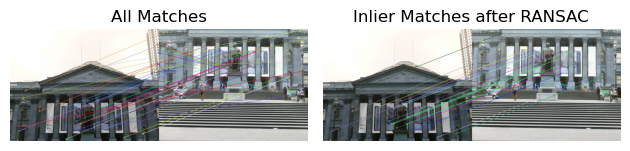

shape of warmped (4, 2)
shape of tmpwarmped (4, 2)
new cords [array([ -41.84071534, -272.60465444]), array([ 624.0978896 , -257.46524745]), array([578.34097224, 223.58633593]), array([  0.55656561, 215.84391545])]
new corners are  [[-4.1840714e+01 -2.7260464e+02]
 [ 6.2409790e+02 -2.5746524e+02]
 [ 5.7834094e+02  2.2358633e+02]
 [ 5.5656564e-01  2.1584392e+02]]


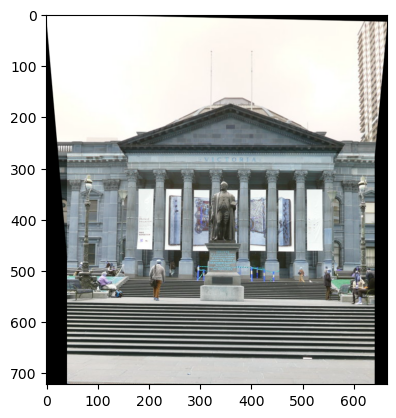

img1 path ../Data/Train/Set1/stitched_result.jpg
img2 path ../Data/Train/Set1/3.jpg


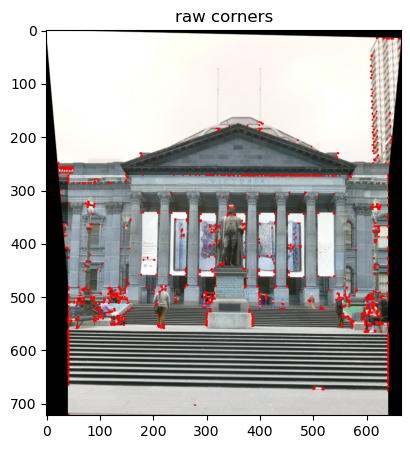

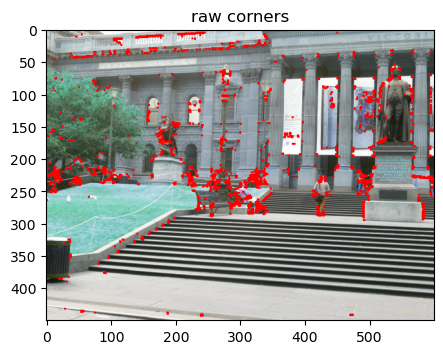

[ANMS] Total number of local maxima keypoints 893


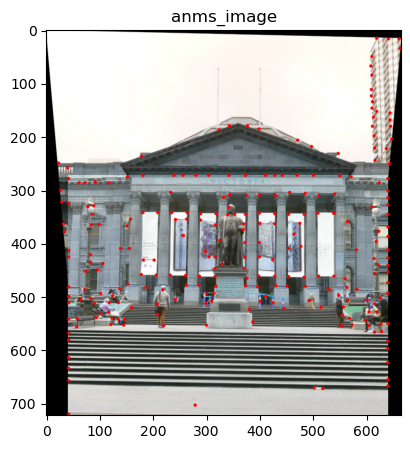

[ANMS] Total number of local maxima keypoints 948


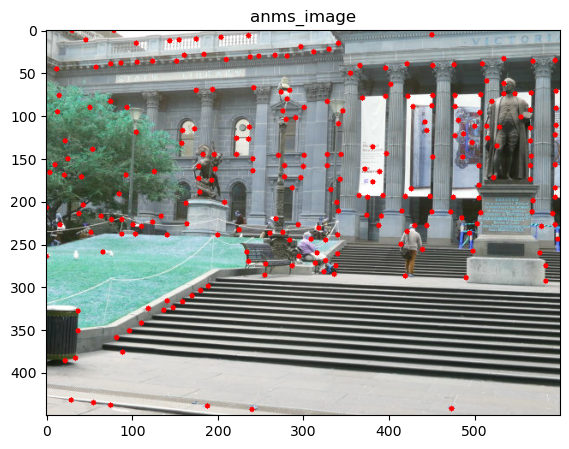

[Match Features] Feature descriptors 1 length:  250
[Match Features] Feature descriptors 2 length:  250
best h is  [[ 8.01936260e-01 -2.26299763e-02  2.07977336e+02]
 [-5.13851181e-02  9.01557061e-01 -2.25287915e+02]
 [-2.45880972e-04 -6.29279725e-05  1.00000000e+00]]
best h is  [[-2.57346517e-03  5.15350049e-05 -6.76940938e-01]
 [ 2.01822216e-04 -2.96236166e-03  7.36019605e-01]
 [ 9.58516972e-07  1.34336791e-07 -3.26568145e-03]]
new_list len 31,31


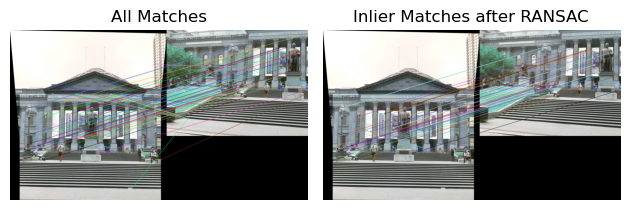

shape of warmped (4, 2)
shape of tmpwarmped (4, 2)
new cords [array([ 207.2893356 , -225.38009791]), array([ 908.69560481, -331.10454852]), array([928.81476991, 501.16758818]), array([201.89182487, 442.70830704])]
new corners are  [[ 207.28934 -225.3801 ]
 [ 908.6956  -331.10455]
 [ 928.81476  501.1676 ]
 [ 201.89183  442.7083 ]]


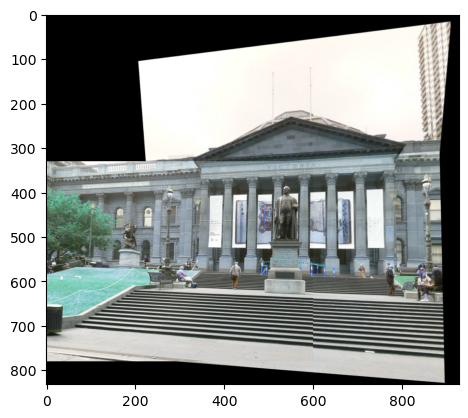

In [23]:

if __name__ == "__main__":
    main()